![Banner logo](https://raw.githubusercontent.com/CitrineInformatics/community-tools/master/templates/fig/citrine_banner_2.png)

# Citrination t-SNE API

*Authors: Erin Antono, Enze Chen*

In this tutorial, we're going to learn to use Citrination to generate a useful data analysis called t-SNE. This data visualization technique enables you to represent a high dimensional set of data in fewer dimensions in a way that preserves the local structure of the data. In materials informatics, this allows you to create a two-dimensional plot of a set of materials where points corresponding to similar materials are grouped together in two-dimensional space. More information on t-SNE here: https://lvdmaaten.github.io/tsne/

This tutorial will teach you to create and export a two-dimensional t-SNE plot for any data on Citrination. The first step is to create a [data view on Citrination](https://citrination.com/data_views). We have instructions for doing so through the [UI](../citrination_ui_examples/03_data_views.md) and [API](clients_sequence/2_data_views_client_api_tutorial.ipynb).

We'll be using [this data view](https://citrination.com/data_views/4106) (view id `4106`) for this tutorial, which includes a model predicting experimental band gaps based on data compiled by W.H. Strehlow and E.L. Cook, which can be viewed in [this dataset](https://citrination.com/datasets/1160/show_search).

## Python package imports

In [1]:
# Standard packages
import os

# Third-party packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from citrination_client import CitrinationClient

## Get the t-SNE projections

In [2]:
# Initialize the CitrinationClient
site = "https://citrination.com" # public
client = CitrinationClient(api_key=os.environ["CITRINATION_API_KEY"], site=site)

tsne_view_id = "4106"
tsne = client.models.tsne(tsne_view_id)
print(tsne.projections())

dict_keys(['Property Color', 'Property Band gap'])


The `tsne` call returns a dictionary where the top level keys correspond to the properties that are being modeled. In this data view, the model inputs are `Chemical formula` and `Crystallinity`. Citrination represents a chemical formula by calculating over 50 material descriptors. The t-SNE plot reduces that into just 2 dimensions. Let's look at the t-SNE plot for `Band gap`.

In [3]:
[x for x in dir(tsne.get_projection("Property Band gap")) if not x.startswith('_')]

['responses', 'tags', 'uids', 'xs', 'ys']

- `x` is the x component of the t-SNE plot
- `y` is the y component of the t-SNE plot
- `z` is the property value (Band gap in this example)
- `uid` is the uid of the record on Citrination. You can find the record by going to https://citrination.com/pif/{uid}
- `label` is the list of the values of the model inputs for the record

## Plot the t-SNE projection

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


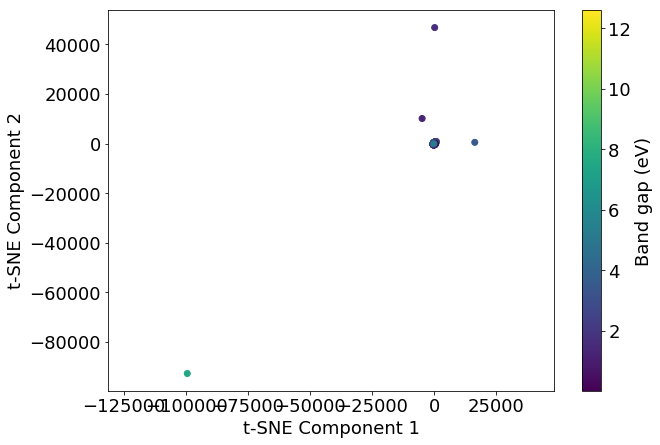

In [4]:
gap_projection = tsne.get_projection("Property Band gap")

plt.rcParams.update({'figure.figsize':(10,7), 'font.size':18})
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

When interpreting a t-SNE plot, keep in mind that the t-SNE components plotted on the $x$ and $y$ axes have no physical meaning. Since the t-SNE algorithm preserves the local structure of the data, we look at points that end up close together. Just from looking at the plot, we can see that there are a few clusters of materials; let's take a look at what those materials are.

(Note: t-SNE is a non-deterministic algorithm, so the plot will change if the underlying Data View is retrained)

## Inspect candidates of interest more closely

In [5]:
# Load the coordinates and band gap values into a numpy array
coordinates_and_bg = np.zeros((len(gap_projection.xs), 3))
coordinates_and_bg[:,0] = gap_projection.xs
coordinates_and_bg[:,1] = gap_projection.ys
coordinates_and_bg[:,2] = gap_projection.responses

In [6]:
# Find the n materials closest to the target material, as specified by index
# based on cartesian distance in the t-SNE coordinates
def find_most_similar_materials(index, coordinates, n_materials=10):
    distances = np.linalg.norm(coordinates_and_bg[:,0:2] - coordinates_and_bg[index,0:2], axis=1)
    return np.argsort(distances)[1:n_materials+1]

From inspecting this cluster of materials, we can see that the t-SNE plot has grouped highly ionic materials together, and that these materials have very high band gaps.

Maximum band gap material:
White, Single crystalline, 12.6, InorganicChemicalFormula(LiF), Band gap: 12.6, URL: https://citrination.com/pif/1160/3/13E97D0A1EA5421734E8B28BE4833CDD
Similar materials:
White, Single crystalline, 10.0, InorganicChemicalFormula(CaF2), Band gap: 10.0, URL: https://citrination.com/pif/1160/3/012C3CF2A38EE5F613B4FA2C559D2007
White, Single crystalline, 9.06, InorganicChemicalFormula(BaF2), Band gap: 9.06, URL: https://citrination.com/pif/1160/3/60124122C825682FAE018D72622D3701
White, Single crystalline, 6.6, InorganicChemicalFormula(LaF3), Band gap: 6.6, URL: https://citrination.com/pif/1160/3/8AA7BD5AC1AF7B34BC654F8D2C5C7294
White, Single crystalline, 5.65, InorganicChemicalFormula(MgF2), Band gap: 5.65, URL: https://citrination.com/pif/1160/3/EC2A1B4932B922909EEF9F078E77AF2D
White, Polycrystalline, 5.3, InorganicChemicalFormula(PrF3), Band gap: 5.3, URL: https://citrination.com/pif/1160/3/308A130DBCD8DB5FF8BC3D48004ADD47
White, Polycrystalline, 6.15, Inorgani

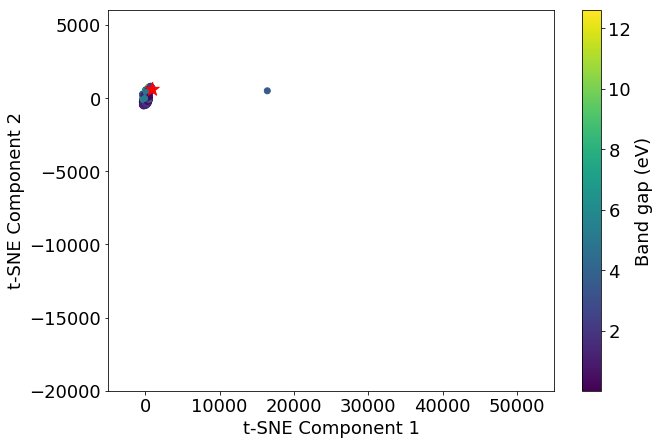

In [7]:
# Get the index of the maximum band gap material
max_bg_index = np.argmax(coordinates_and_bg, axis=0)[2]
print("Maximum band gap material:")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[max_bg_index], 
              gap_projection.responses[max_bg_index],
              gap_projection.uids[max_bg_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(max_bg_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(gap_projection.tags[idx],
                  gap_projection.responses[idx],
                  gap_projection.uids[idx])
         )

plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[max_bg_index, 0], coordinates_and_bg[max_bg_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
#plt.axes().set_aspect('equal', 'datalim')
print(min(gap_projection.xs), max(gap_projection.xs), min(gap_projection.ys), max(gap_projection.ys))
plt.xlim(-5000,55000)
plt.ylim(-20000,6000)
plt.show()

Now let's figure out what material the outlier point with the largest y-value corresponds to

Outlier material (point with the highest y-value):
Dark Gray, Single crystalline, 1.7, InorganicChemicalFormula(Nd2Se3), Band gap: 1.7, URL: https://citrination.com/pif/1160/3/2E2843A1037182C8D8E93189E51FF263
-99490.86314086402 16418.04651837653 -92695.26470012423 46771.87163559855


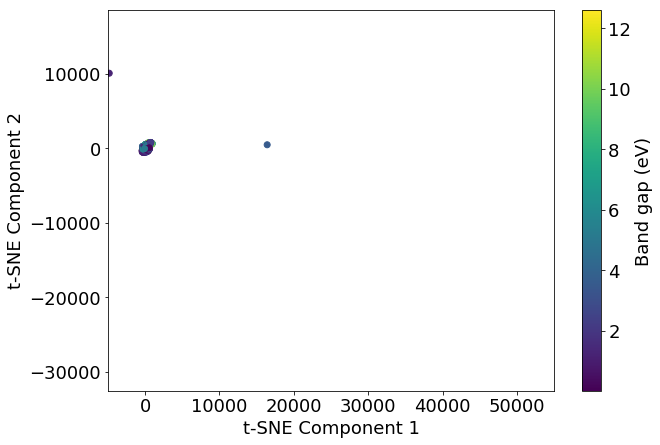

In [8]:
outlier_index = np.argmax(coordinates_and_bg, axis=0)[1]
print("Outlier material (point with the highest y-value):")
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[outlier_index],
              gap_projection.responses[outlier_index],
              gap_projection.uids[outlier_index])
     )

plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[outlier_index, 0], coordinates_and_bg[outlier_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
print(min(gap_projection.xs), max(gap_projection.xs), min(gap_projection.ys), max(gap_projection.ys))
plt.xlim(-5000,55000)
plt.ylim(-20000,6000)
plt.axes().set_aspect('equal', 'datalim')
plt.show()

We can also find materials that are similar to a given material in the dataset. Let's find materials similar to HgSe https://citrination.com/datasets/1160/version/3/pif/F7DF9D76620C95CD45BD41881D96E174. The uid comes in the format dataset_id/version/pif_id. For HgSe, the uid is 1160/3/F7DF9D76620C95CD45BD41881D96E174.

Red, Single crystalline, 0.07, InorganicChemicalFormula(HgSe), Band gap: 0.07, URL: https://citrination.com/pif/1160/3/F7DF9D76620C95CD45BD41881D96E174
Similar materials:
White, Single crystalline, 0.266, InorganicChemicalFormula(HgTe), Band gap: 0.266, URL: https://citrination.com/pif/1160/3/87E0656F175E0FC28B0E2606D59EF004
Red, Single crystalline, 0.54, InorganicChemicalFormula(HgS), Band gap: 0.54, URL: https://citrination.com/pif/1160/3/55171B08FC613D6D17427EB1C02997C9
Yellow, Single crystalline, 2.37, InorganicChemicalFormula(Hg2I2), Band gap: 2.37, URL: https://citrination.com/pif/1160/3/E685FF1FE347D6F620D15CBBA9F38C21
Red, Polycrystalline, 2.0, InorganicChemicalFormula(MnTe9), Band gap: 2.0, URL: https://citrination.com/pif/1160/3/34CFD14D10D6C120385838F4FE32F87E
Red, Polycrystalline, 3.306, InorganicChemicalFormula(CuCl), Band gap: 3.306, URL: https://citrination.com/pif/1160/3/4BE3F7974B131A7769078DF345B5F55A
Yellow, Single crystalline, 2.315, InorganicChemicalFormula(HgI2), 

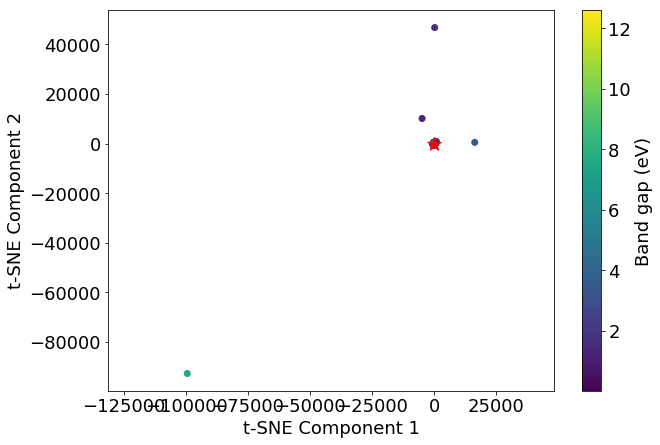

In [9]:
uid = '1160/3/F7DF9D76620C95CD45BD41881D96E174'
cr3se4_index = gap_projection.uids.index(uid)
print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
      .format(gap_projection.tags[cr3se4_index],
              gap_projection.responses[cr3se4_index],
              gap_projection.uids[cr3se4_index])
     )
print("Similar materials:")
for idx in find_most_similar_materials(cr3se4_index, coordinates_and_bg[:,0:2]):
    print("{}, Band gap: {}, URL: https://citrination.com/pif/{}"
          .format(gap_projection.tags[idx],
                  gap_projection.responses[idx],
                  gap_projection.uids[idx])
         )
plt.figure()
plt.scatter(gap_projection.xs, gap_projection.ys, c=gap_projection.responses)
plt.colorbar(label="Band gap (eV)")
plt.scatter(coordinates_and_bg[cr3se4_index, 0], coordinates_and_bg[cr3se4_index, 1],
            marker="*", c="r", s=200)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.axes().set_aspect('equal', 'datalim')
plt.show()

As we've seen here, t-SNE is a useful tool for understanding materials datasets and gaining new insights by visualizing and exploring a large, high-dimensional dataset in two dimensions. In this tutorial, we've seen how to examine outliers, find interesting clusters of similar materials, and find materials that are similar to a given material, which are only some of the cool things that you can do with t-SNE plots. The t-SNE analysis is available for all real-valued outputs specified in the Data Views creation process.